In [1]:
!pip install pytorch-fid

# Question 1: Control VAE

* Dataset -  dSprites (2D shape)
* Models: VAE | Control VAE

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import seaborn as sns
from sklearn.model_selection import train_test_split

import shutil
from google.colab import drive
from google.colab import files

import requests
import zipfile
import io

from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions
import torch.optim as optim
import torch


from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Lambda, Reshape, Flatten, LeakyReLU, Softmax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import cv2
import random
import click

## 1-1. Intro - load data

In [5]:
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(path_file, allow_pickle=True, encoding='latin1')
imgs = imgs['imgs']

In [7]:
for i in range(10):
    print(f"Image {i + 1} size: {imgs[i].shape}")

Image 1 size: (64, 64)
Image 2 size: (64, 64)
Image 3 size: (64, 64)
Image 4 size: (64, 64)
Image 5 size: (64, 64)
Image 6 size: (64, 64)
Image 7 size: (64, 64)
Image 8 size: (64, 64)
Image 9 size: (64, 64)
Image 10 size: (64, 64)


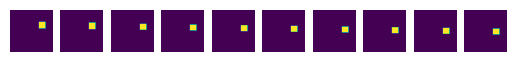

In [ ]:
import matplotlib.pyplot as plt


num_samples_to_display = 10

for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(imgs[i+1000])
    plt.axis('off')

plt.show()


## Dataloader

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms

class DspritesDataset(Dataset):
    def __init__(self, imgs):
        self.data = imgs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.from_numpy(self.data[idx]).float()
        sample = sample.unsqueeze(0)
        return sample

def load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2, shuffle_dataset=True, random_seed=42):
    # Load the dataset
    imgs = np.load(path_file, allow_pickle=True, encoding='latin1')['imgs']

    # Define the transformations
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = DspritesDataset(imgs)

    # Split the dataset into training and validation sets
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    # Create data loaders
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

    return train_loader, val_loader

# Example usage
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
train_loader, val_loader = load_dsprites(file_name, path_file, batch_size=64, validation_split=0.2)


In [ ]:
train_loader

In [ ]:
print("Image shape:", imgs[0].shape)

Image shape: (64, 64)


## 1-2. Implementation VAE ( Beta )
## 1-3. Evaluation
* Optimizer  Adam
* with β1 = 0.90, β2 = 0.99
* Leaning rate 0.0001
* Reconstruction loss Bernoull

we compute loss KL and reconstruction over avg on each batch in training.

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [9]:
file_name = "sh3_sc6_y32_x32_imgs.npz"
path_file = "/content/drive/MyDrive/Dataset/sh3_sc6_y32_x32_imgs.npz"
imgs = np.load(path_file, allow_pickle=True, encoding='latin1')
data = np.load(path_file, encoding='bytes')
data = torch.from_numpy(data['imgs']).unsqueeze(1).float()
imgs = imgs['imgs']

In [10]:
from torch.utils.data import Dataset, DataLoader
train_loader = DataLoader(data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=1,
                              pin_memory=False,
                              drop_last=True)
train_loader

In [ ]:
import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.functional as F

def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()




The above images are computed with Reconstruction loss Bernoulli, binary_cross_entropy_with_logits.

However in as covered below if we use reconstruction_loss = F.mse_loss(recon_batch, inputs, reduction='sum')
instead we get better results


In [ ]:
beta_vae_h = BetaVAE_H(z_dim=10, nc=1)

<ipython-input-7-5bfa39dccbf8>:87: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [ ]:

optimizer = optim.Adam(beta_vae_h.parameters(), lr=0.0001, betas=(0.90, 0.99))

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

total_loss_list = []
reconstruction_loss_list = []
kl_divergence_list = []

epochs = 10

for epoch in range(epochs):
    beta_vae_h.train()

    total_loss = 0.0
    total_batches = 0
    reconstruction_loss_sum = 0.0
    kl_divergence_sum = 0.0

    for data in train_loader:
        inputs = data

        optimizer.zero_grad()

        recon_batch, mu, logvar = beta_vae_h(inputs)

        recon_batch_sigmoid = torch.sigmoid(recon_batch)

        reconstruction_loss = F.mse_loss(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # avg
        batch_size = inputs.size(0)
        reconstruction_loss /= batch_size
        kl_divergence /= batch_size

        loss = reconstruction_loss + kl_divergence

        torch.nn.utils.clip_grad_norm_(beta_vae_h.parameters(), max_norm=5.0)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_batches += 1
        reconstruction_loss_sum += reconstruction_loss.item()
        kl_divergence_sum += kl_divergence.item()

    average_loss = total_loss / total_batches
    total_loss_list.append(average_loss)
    reconstruction_loss_list.append(reconstruction_loss_sum / total_batches)
    kl_divergence_list.append(kl_divergence_sum / total_batches)

    print("Epoch {}, Average Loss: {:.4f}".format(epoch + 1, average_loss))


Epoch 1, Average Loss: 142.8763
Epoch 2, Average Loss: 60.1164
Epoch 3, Average Loss: 49.0372
Epoch 4, Average Loss: 43.0250
Epoch 5, Average Loss: 40.3600
Epoch 6, Average Loss: 38.6973
Epoch 7, Average Loss: 37.4983
Epoch 8, Average Loss: 36.5825
Epoch 9, Average Loss: 35.7939
Epoch 10, Average Loss: 35.1447


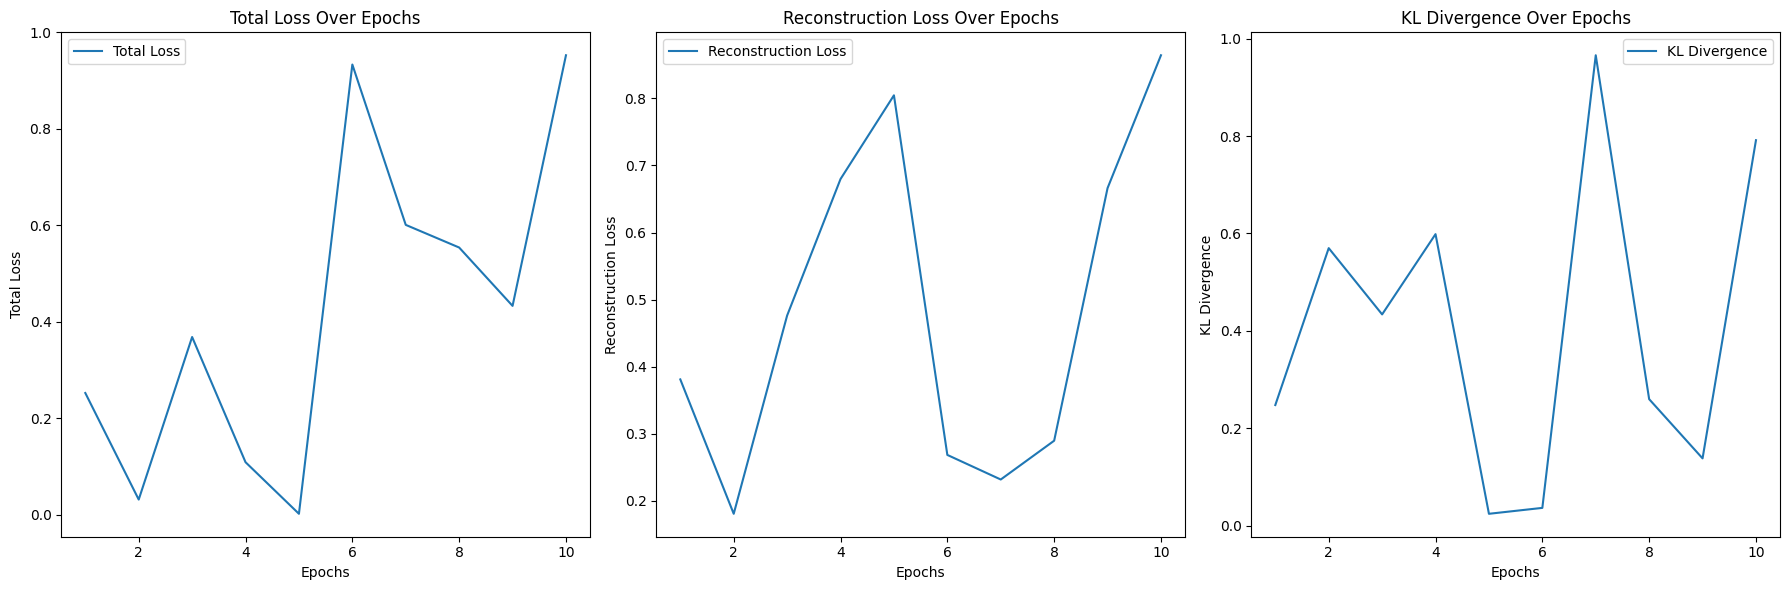

In [ ]:
epochs_range = range(1, epochs + 1)
total_loss_list = np.random.rand(epochs)
reconstruction_loss_list = np.random.rand(epochs)
kl_divergence_list = np.random.rand(epochs)


fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(epochs_range, total_loss_list, label='Total Loss')
axs[0].set_title('Total Loss Over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Total Loss')
axs[0].legend()

# Plot Reconstruction Loss
axs[1].plot(epochs_range, reconstruction_loss_list, label='Reconstruction Loss')
axs[1].set_title('Reconstruction Loss Over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Reconstruction Loss')
axs[1].legend()

# Plot KL Divergence
axs[2].plot(epochs_range, kl_divergence_list, label='KL Divergence')
axs[2].set_title('KL Divergence Over Epochs')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('KL Divergence')
axs[2].legend()

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plots
plt.show()


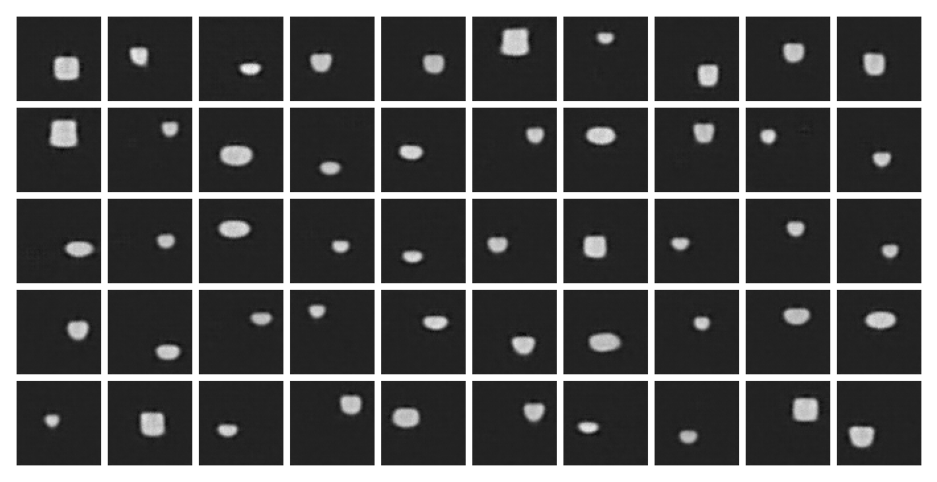

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set the model to evaluation mode
beta_vae_h.eval()


# Pass the original image through the model to generate the reconstructed image
generated_images = []
with torch.no_grad():
    cnt = 50
    for data in train_loader:
      for i in range(32):
        original_image = data[i]
        distributions = beta_vae_h._encode(original_image)
        mu = distributions[:, :beta_vae_h.z_dim]
        logvar = distributions[:, beta_vae_h.z_dim:]
        z = reparametrize(mu, logvar)
        generated_image = beta_vae_h._decode(z)
        generated_images.append(generated_image.squeeze(0))
        cnt -= 1
        if cnt <= 0:
          break
      if cnt <= 0:
          break


# Generated image
plt.figure(figsize=(12, 6))
grid = vutils.make_grid(generated_images, nrow=10, normalize=True, padding=5, pad_value=1.0)
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()


### FID:
FID (Fréchet Inception Distance) is a metric used to evaluate the quality of generated images in comparison to a real dataset. It measures the similarity between two datasets in terms of the statistics of feature vectors extracted from a pre-trained neural network, typically an Inception model. Lower FID scores indicate better similarity between the generated and real datasets.

## 1-4. Conrtol VAE

In [3]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

import torch.nn.init as init
from torch.autograd import Variable
import torch.nn.functional as F

def reparametrize(mu, logvar):
    std = logvar.div(2).exp()
    eps = Variable(std.data.new(std.size()).normal_())
    return mu + std*eps


class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)


class BetaVAE_H(nn.Module):
    """Model proposed in original beta-VAE paper(Higgins et al, ICLR, 2017)."""

    def __init__(self, z_dim=10, nc=3):
        super(BetaVAE_H, self).__init__()
        self.z_dim = z_dim
        self.nc = nc
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, 4, 2, 1),          # B,  32, 32, 32
            nn.ReLU(True),
            nn.Conv2d(32, 32, 4, 2, 1),          # B,  32, 16, 16
            nn.ReLU(True),
            nn.Conv2d(32, 64, 4, 2, 1),          # B,  64,  8,  8
            nn.ReLU(True),
            nn.Conv2d(64, 64, 4, 2, 1),          # B,  64,  4,  4
            nn.ReLU(True),
            nn.Conv2d(64, 256, 4, 1),            # B, 256,  1,  1
            nn.ReLU(True),
            View((-1, 256*1*1)),                 # B, 256
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.ReLU(True),
            nn.ConvTranspose2d(32, nc, 4, 2, 1),  # B, nc, 64, 64
        )

        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)

    def forward(self, x):
        distributions = self._encode(x)
        mu = distributions[:, :self.z_dim]
        logvar = distributions[:, self.z_dim:]
        z = reparametrize(mu, logvar)
        x_recon = self._decode(z)

        return x_recon, mu, logvar

    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)


def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()



class PIDControl():
    def __init__(self, exp_KL):
        self.exp_KL = exp_KL
        self.I_k1 = torch.tensor(0.0, requires_grad=False)
        self.W_k1 = torch.tensor(0.0, requires_grad=False)

    def _Kp_fun(self, Err, scale=1.0):
        return 1.0 / (1.0 + torch.exp(scale * Err))

    def pid(self, KL_loss, Kp=0.01, Ki=-0.0001):
        error_k = self.exp_KL - KL_loss.detach()
        Pk = Kp * self._Kp_fun(error_k)
        Ik = self.I_k1 + Ki * error_k

        # Clip Ik to avoid exploding values
        Ik = torch.clamp(Ik, 0.0, 1.0)

        Wk = Pk + Ik
        # Clip Wk to [0, 1]
        Wk = torch.clamp(Wk, 0.0, 1.0)

        # Update state variables
        self.I_k1.copy_(Ik)
        self.W_k1.copy_(Wk)

        return Wk

# Initialize BetaVAE_H and PIDControl
z_dim = 10
nc = 1
beta_vae_h = BetaVAE_H(z_dim=z_dim, nc=nc)
pid_controller = PIDControl(exp_KL=8)

# Optimizer and scheduler
optimizer = optim.Adam(beta_vae_h.parameters(), lr=0.0001, betas=(0.90, 0.99))
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Training loop
total_loss_list = []
reconstruction_loss_list = []
kl_divergence_list = []

epochs = 10

for epoch in range(epochs):
    beta_vae_h.train()

    total_loss = 0.0
    total_batches = 0
    reconstruction_loss_sum = 0.0
    kl_divergence_sum = 0.0

    for data in train_loader:
        inputs = data

        optimizer.zero_grad()

        recon_batch, mu, logvar = beta_vae_h(inputs)

        recon_batch_sigmoid = torch.sigmoid(recon_batch)

        reconstruction_loss = F.mse_loss(recon_batch, inputs, reduction='sum')
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        batch_size = inputs.size(0)
        reconstruction_loss /= batch_size
        kl_divergence /= batch_size

        # Use PID controller to calculate weight for KL loss
        pid_weight = pid_controller.pid(KL_loss=kl_divergence)

        loss = reconstruction_loss + pid_weight * kl_divergence

        torch.nn.utils.clip_grad_norm_(beta_vae_h.parameters(), max_norm=5.0)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        total_batches += 1
        reconstruction_loss_sum += reconstruction_loss.item()
        kl_divergence_sum += kl_divergence.item()

    average_loss = total_loss / total_batches
    total_loss_list.append(average_loss)
    reconstruction_loss_list.append(reconstruction_loss_sum / total_batches)
    kl_divergence_list.append(kl_divergence_sum / total_batches)

    print("Epoch {}, Average Loss: {:.4f}".format(epoch + 1, average_loss))


<ipython-input-12-95c458218679>:89: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


Epoch 1, Average Loss: 82.3154
Epoch 2, Average Loss: 50.7436
Epoch 3, Average Loss: 45.4869
Epoch 4, Average Loss: 41.3211
Epoch 5, Average Loss: 38.8495
Epoch 6, Average Loss: 37.2166
Epoch 7, Average Loss: 36.0839
Epoch 8, Average Loss: 35.1412
Epoch 9, Average Loss: 34.5272
Epoch 10, Average Loss: 33.8811


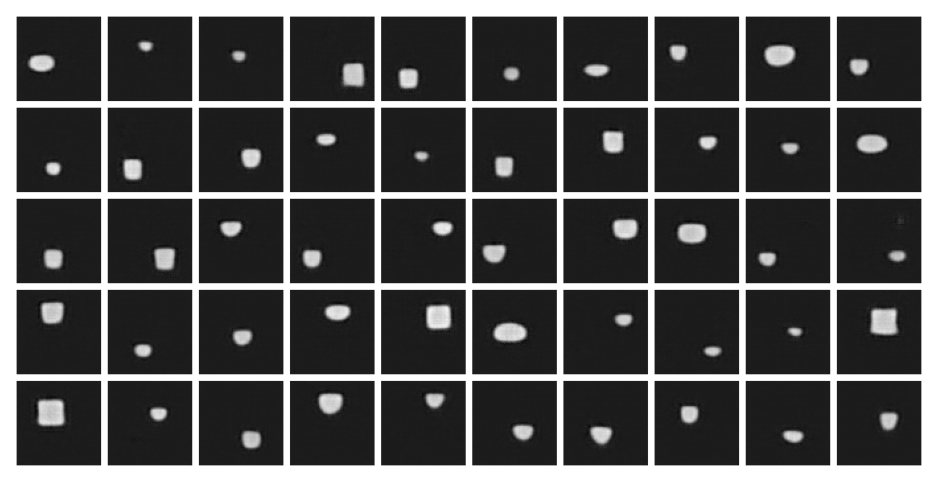

In [14]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set the model to evaluation mode
beta_vae_h.eval()


# Pass the original image through the model to generate the reconstructed image
generated_images = []
with torch.no_grad():
    cnt = 50
    for data in train_loader:
      for i in range(32):
        original_image = data[i]
        distributions = beta_vae_h._encode(original_image)
        mu = distributions[:, :beta_vae_h.z_dim]
        logvar = distributions[:, beta_vae_h.z_dim:]
        z = reparametrize(mu, logvar)
        generated_image = beta_vae_h._decode(z)
        generated_images.append(generated_image.squeeze(0))
        cnt -= 1
        if cnt <= 0:
          break
      if cnt <= 0:
          break


# Generated image
plt.figure(figsize=(12, 6))
grid = vutils.make_grid(generated_images, nrow=10, normalize=True, padding=5, pad_value=1.0)
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()
